# Chapter 10 - Unsupervised Learning 

In [3]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.cluster import hierarchy

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', 150)
 
%config InlineBackend.figure_formats = {'png',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

## Lab 1 : Principal Component Analysis

In [4]:
# In R, I exported the dataset to a csv file. It is part of the base R distribution.
df = pd.read_csv('Data/USArrests.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
Murder      50 non-null float64
Assault     50 non-null int64
UrbanPop    50 non-null int64
Rape        50 non-null float64
dtypes: float64(2), int64(2)
memory usage: 1.8+ KB


In [5]:
df.mean()

Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

In [6]:
df.var()

Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

In [7]:
X = pd.DataFrame(scale(df), index=df.index, columns=df.columns)

In [8]:
# The loading vectors
pca_loadings = pd.DataFrame(PCA().fit(X).components_.T, index=df.columns, columns=['V1', 'V2', 'V3', 'V4'])
pca_loadings

                V1        V2        V3        V4
Murder   -0.535899  0.418181 -0.341233  0.649228
Assault  -0.583184  0.187986 -0.268148 -0.743407
UrbanPop -0.278191 -0.872806 -0.378016  0.133878
Rape     -0.543432 -0.167319  0.817778  0.089024

In [9]:
# Fit the PCA model and transform X to get the principal components
pca = PCA()
df_plot = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2', 'PC3', 'PC4'], index=X.index)
df_plot

                     PC1       PC2       PC3       PC4
Alabama        -0.985566  1.133392 -0.444269  0.156267
Alaska         -1.950138  1.073213  2.040003 -0.438583
Arizona        -1.763164 -0.745957  0.054781 -0.834653
Arkansas        0.141420  1.119797  0.114574 -0.182811
California     -2.523980 -1.542934  0.598557 -0.341996
Colorado       -1.514563 -0.987555  1.095007  0.001465
Connecticut     1.358647 -1.088928 -0.643258 -0.118469
Delaware       -0.047709 -0.325359 -0.718633 -0.881978
Florida        -3.013042  0.039229 -0.576829 -0.096285
Georgia        -1.639283  1.278942 -0.342460  1.076797
Hawaii          0.912657 -1.570460  0.050782  0.902807
Idaho           1.639800  0.210973  0.259801 -0.499104
Illinois       -1.378911 -0.681841 -0.677496 -0.122021
Indiana         0.505461 -0.151563  0.228055  0.424666
Iowa            2.253646 -0.104054  0.164564  0.017556
Kansas          0.796881 -0.270165  0.025553  0.206496
Kentucky        0.750859  0.958440 -0.028369  0.670557
Louisiana 

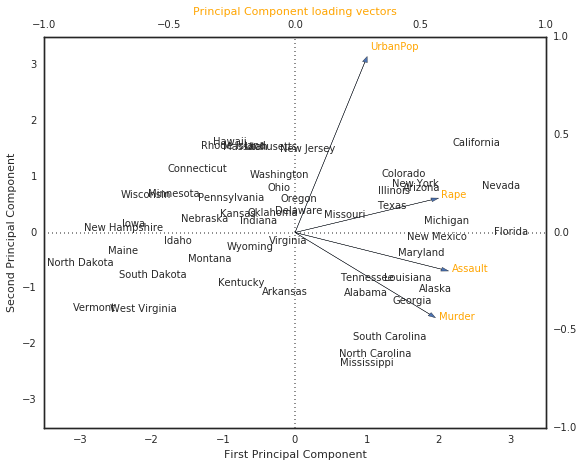

In [10]:
fig , ax1 = plt.subplots(figsize=(9,7))

ax1.set_xlim(-3.5,3.5)
ax1.set_ylim(-3.5,3.5)

# Plot Principal Components 1 and 2
for i in df_plot.index:
    ax1.annotate(i, (-df_plot.PC1.loc[i], -df_plot.PC2.loc[i]), ha='center')

# Plot reference lines
ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
    
# Plot Principal Component loading vectors, using a second y-axis.
ax2 = ax1.twinx().twiny() 

ax2.set_ylim(-1,1)
ax2.set_xlim(-1,1)
ax2.tick_params(axis='y', colors='orange')
ax2.set_xlabel('Principal Component loading vectors', color='orange')

# Plot labels for vectors. Variable 'a' is a small offset parameter to separate arrow tip and text.
a = 1.07  
for i in pca_loadings[['V1', 'V2']].index:
    ax2.annotate(i, (-pca_loadings.V1.loc[i]*a, -pca_loadings.V2.loc[i]*a), color='orange')

# Plot vectors
ax2.arrow(0,0,-pca_loadings.V1[0], -pca_loadings.V2[0])
ax2.arrow(0,0,-pca_loadings.V1[1], -pca_loadings.V2[1])
ax2.arrow(0,0,-pca_loadings.V1[2], -pca_loadings.V2[2])
ax2.arrow(0,0,-pca_loadings.V1[3], -pca_loadings.V2[3])

In [11]:
# Standard deviation of the four principal components
np.sqrt(pca.explained_variance_)

array([ 1.57487827,  0.99486941,  0.59712912,  0.41644938])

In [12]:
pca.explained_variance_

array([ 2.48024158,  0.98976515,  0.35656318,  0.17343009])

In [13]:
pca.explained_variance_ratio_

array([ 0.62006039,  0.24744129,  0.0891408 ,  0.04335752])

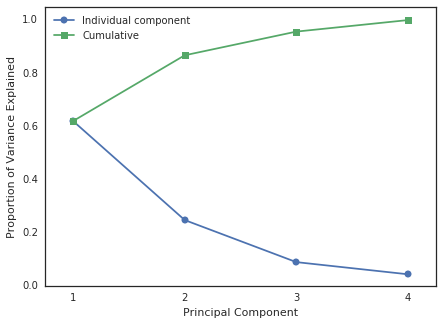

In [14]:
plt.figure(figsize=(7,5))

plt.plot([1,2,3,4], pca.explained_variance_ratio_, '-o', label='Individual component')
plt.plot([1,2,3,4], np.cumsum(pca.explained_variance_ratio_), '-s', label='Cumulative')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4])
plt.legend(loc=2)

## Lab 2: Clustering

### § 10.5.1
#### K-Means Clustering

In [54]:
# Generate data
np.random.seed(2)
X = np.random.standard_normal((50,2))
X[:25,0] = X[:25,0]+3
X[:25,1] = X[:25,1]-4

#### K = 2

In [55]:
km1 = KMeans(n_clusters=2, n_init=20)
km1.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=20,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [56]:
km1.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1])

See plot for K=2 below.

####  K = 3

In [57]:
np.random.seed(4)
km2 = KMeans(n_clusters=3, n_init=20)
km2.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=20,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [58]:
pd.Series(km2.labels_).value_counts()

1    21
0    20
2     9
dtype: int64

In [59]:
km2.cluster_centers_

array([[-0.27876523,  0.51224152],
       [ 2.82805911, -4.11351797],
       [ 0.69945422, -2.14934345]])

In [60]:
km2.labels_

array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1,
       1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2])

In [61]:
# Sum of distances of samples to their closest cluster center.
km2.inertia_

68.973792009397215

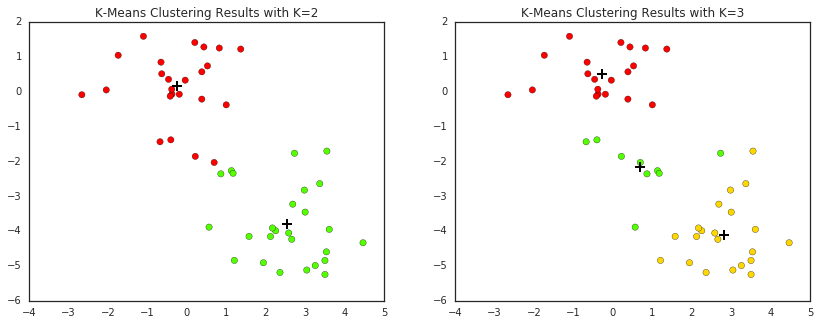

In [66]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.scatter(X[:,0], X[:,1], s=40, c=km1.labels_, cmap=plt.cm.prism) 
ax1.set_title('K-Means Clustering Results with K=2')
ax1.scatter(km1.cluster_centers_[:,0], km1.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2)

ax2.scatter(X[:,0], X[:,1], s=40, c=km2.labels_, cmap=plt.cm.prism) 
ax2.set_title('K-Means Clustering Results with K=3')
ax2.scatter(km2.cluster_centers_[:,0], km2.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2)

### § 10.5.3
### Hierarchical Clustering

#### scipy

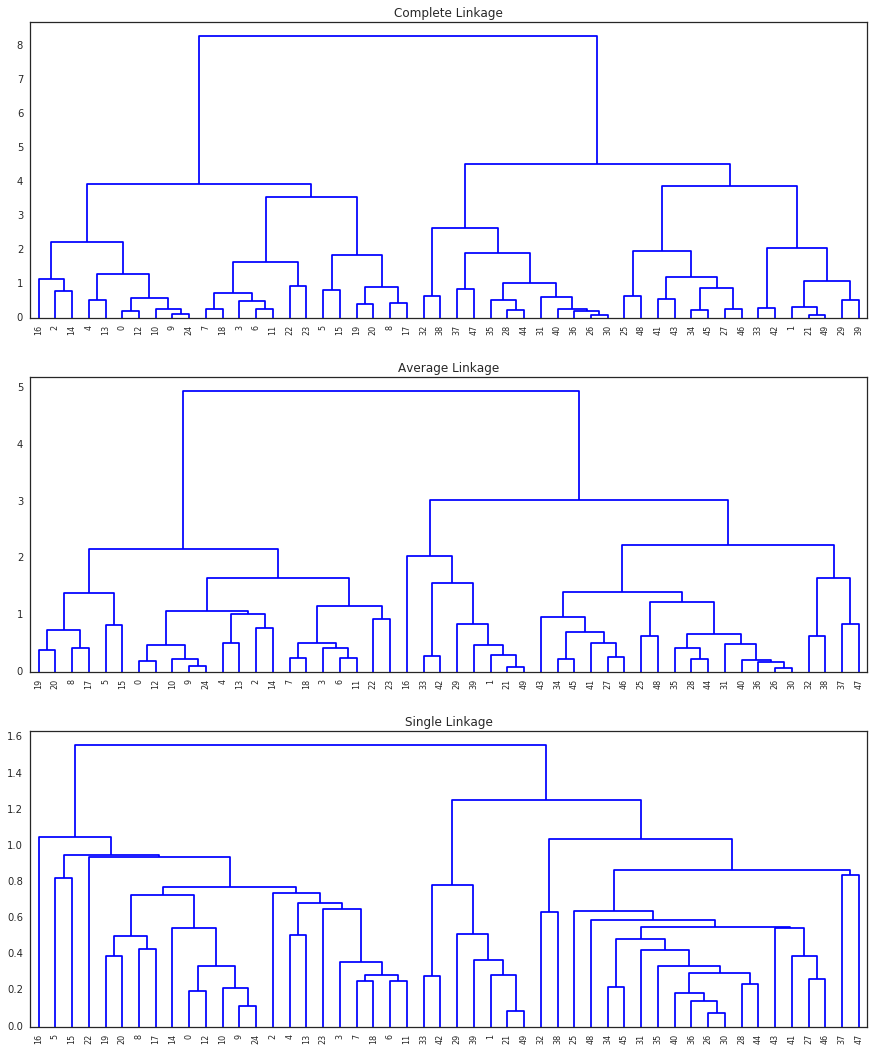

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,18))

for linkage, cluster, ax in zip([hierarchy.complete(X), hierarchy.average(X), hierarchy.single(X)], ['c1','c2','c3'],
                                [ax1,ax2,ax3]):
    cluster = hierarchy.dendrogram(linkage, ax=ax, color_threshold=0)

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage')

## Lab 3: NCI60 Data Example

### § 10.6.1 PCA

In [25]:
# In R, I exported the two elements of this ISLR dataset to csv files.
# There is one file for the features and another file for the classes/types.
df2 = pd.read_csv('Data/NCI60_X.csv').drop('Unnamed: 0', axis=1)
df2.columns = np.arange(df2.columns.size)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 63
Columns: 6830 entries, 0 to 6829
dtypes: float64(6830)
memory usage: 3.3 MB


In [26]:
X = pd.DataFrame(scale(df2))
X.shape

(64, 6830)

In [27]:
y = pd.read_csv('Data/NCI60_y.csv', usecols=[1], skiprows=1, names=['type'])
y.shape

(64, 1)

In [28]:
y.type.value_counts()

NSCLC          9
RENAL          9
MELANOMA       8
BREAST         7
COLON          7
OVARIAN        6
LEUKEMIA       6
CNS            5
PROSTATE       2
K562A-repro    1
MCF7D-repro    1
MCF7A-repro    1
K562B-repro    1
UNKNOWN        1
dtype: int64

In [29]:
# Fit the PCA model and transform X to get the principal components
pca2 = PCA()
df2_plot = pd.DataFrame(pca2.fit_transform(X))

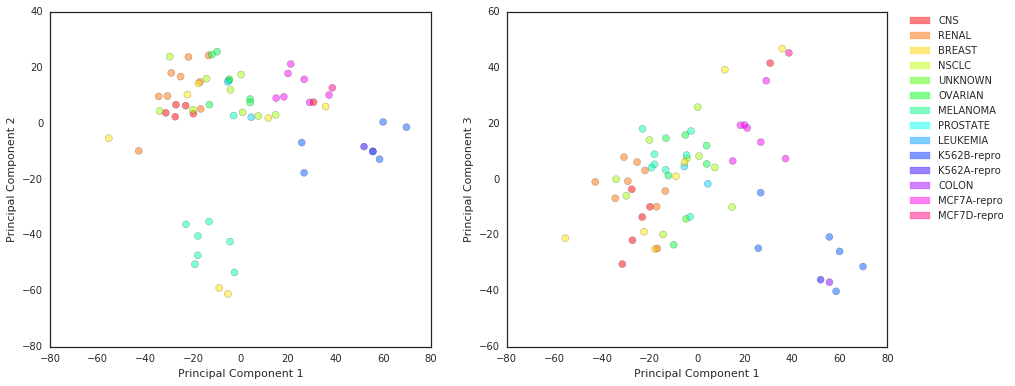

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

color_idx = pd.factorize(y.type)[0]
cmap = mpl.cm.hsv

# Left plot
ax1.scatter(df2_plot.iloc[:,0], df2_plot.iloc[:,1], c=color_idx, cmap=cmap, alpha=0.5, s=50)
ax1.set_ylabel('Principal Component 2')

# Right plot
ax2.scatter(df2_plot.iloc[:,0], df2_plot.iloc[:,2], c=color_idx, cmap=cmap, alpha=0.5, s=50)
ax2.set_ylabel('Principal Component 3')

# Custom legend for the classes (y) since we do not create scatter plots per class (which could have their own labels).
handles = []
labels = pd.factorize(y.type.unique())
norm = mpl.colors.Normalize(vmin=0.0, vmax=14.0)

for i, v in zip(labels[0], labels[1]):
    handles.append(mpl.patches.Patch(color=cmap(norm(i)), label=v, alpha=0.5))

ax2.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# xlabel for both plots
for ax in fig.axes:
    ax.set_xlabel('Principal Component 1')    

In [31]:
pd.DataFrame([df2_plot.iloc[:,:5].std(axis=0, ddof=0).as_matrix(),
              pca2.explained_variance_ratio_[:5],
              np.cumsum(pca2.explained_variance_ratio_[:5])],
             index=['Standard Deviation', 'Proportion of Variance', 'Cumulative Proportion'],
             columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

                              PC1        PC2        PC3        PC4        PC5
Standard Deviation      27.853469  21.481355  19.820465  17.032556  15.971807
Proportion of Variance   0.113589   0.067562   0.057518   0.042476   0.037350
Cumulative Proportion    0.113589   0.181151   0.238670   0.281145   0.318495

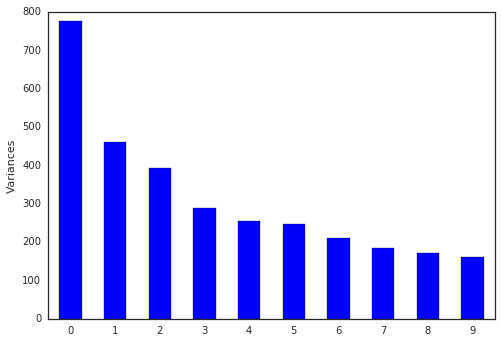

In [32]:
df2_plot.iloc[:,:10].var(axis=0, ddof=0).plot(kind='bar', rot=0)
plt.ylabel('Variances')

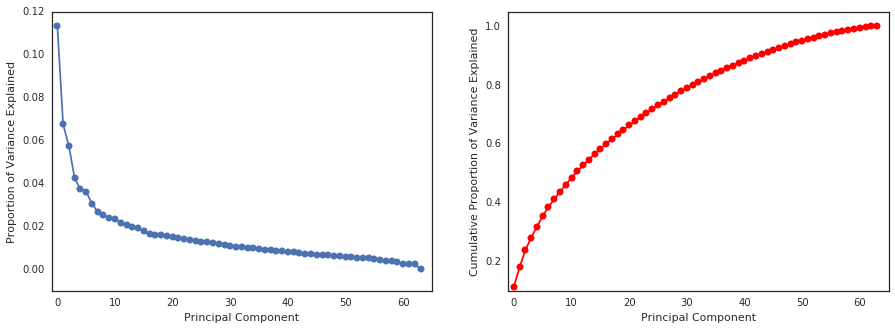

In [33]:
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

# Left plot
ax1.plot(pca2.explained_variance_ratio_, '-o')
ax1.set_ylabel('Proportion of Variance Explained')
ax1.set_ylim(ymin=-0.01)

# Right plot
ax2.plot(np.cumsum(pca2.explained_variance_ratio_), '-ro')
ax2.set_ylabel('Cumulative Proportion of Variance Explained')
ax2.set_ylim(ymax=1.05)

for ax in fig.axes:
    ax.set_xlabel('Principal Component')
    ax.set_xlim(-1,65)    

### § 10.6.2 Clustering

In [34]:
X= pd.DataFrame(scale(df2), index=y.type, columns=df2.columns)

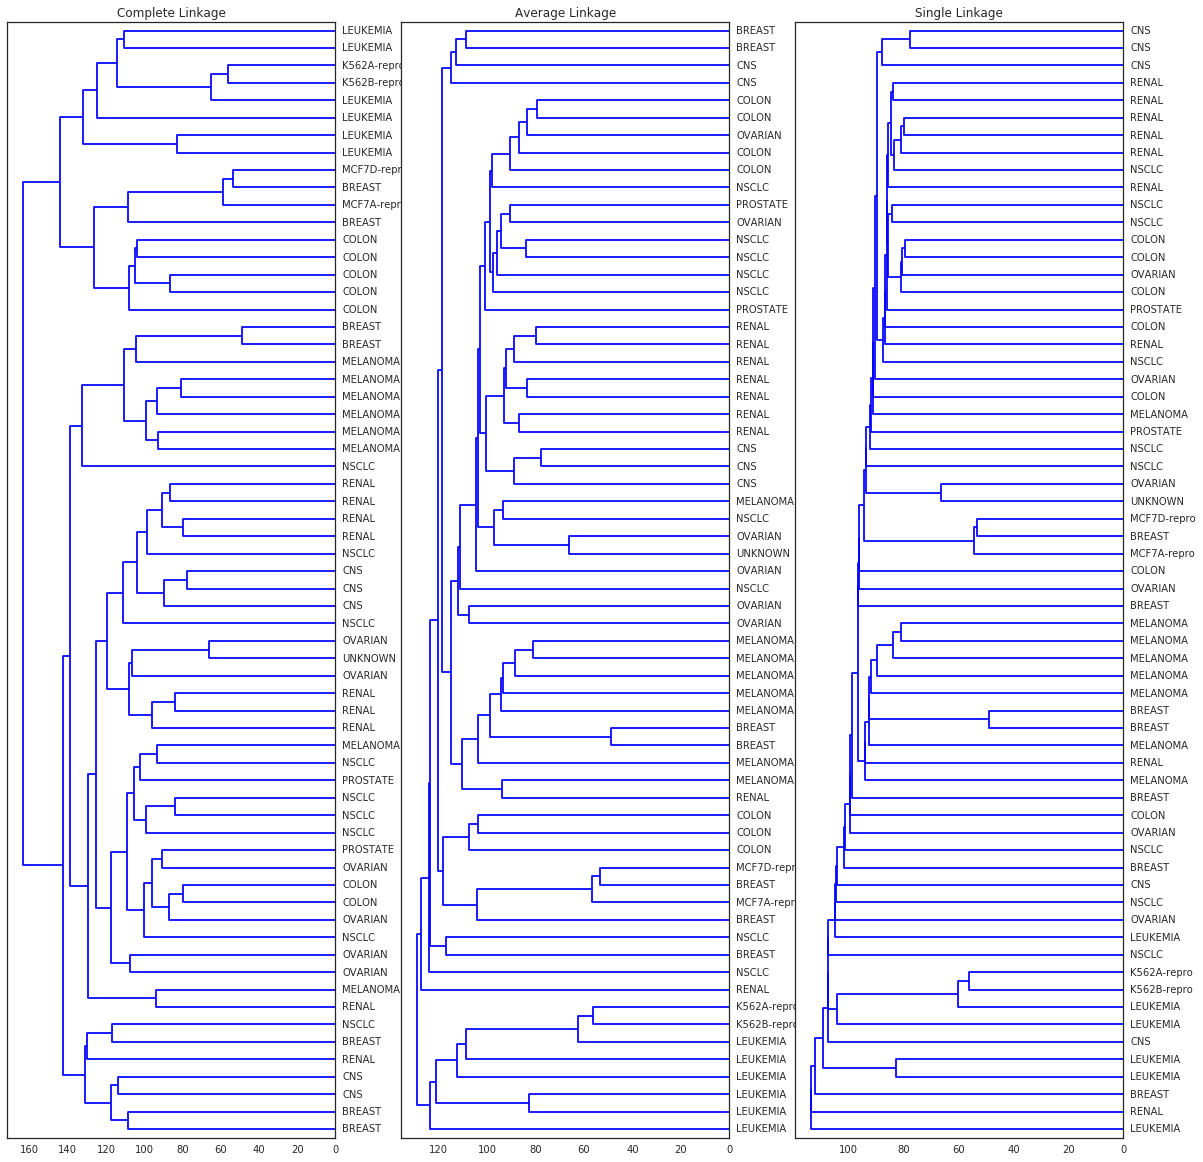

In [43]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,20))

for linkage, cluster, ax in zip([hierarchy.complete(X), hierarchy.average(X), hierarchy.single(X)],
                                ['c1','c2','c3'],
                                [ax1,ax2,ax3]):
    cluster = hierarchy.dendrogram(linkage, labels=X.index, orientation='right', color_threshold=0, leaf_font_size=10, ax=ax)

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage')

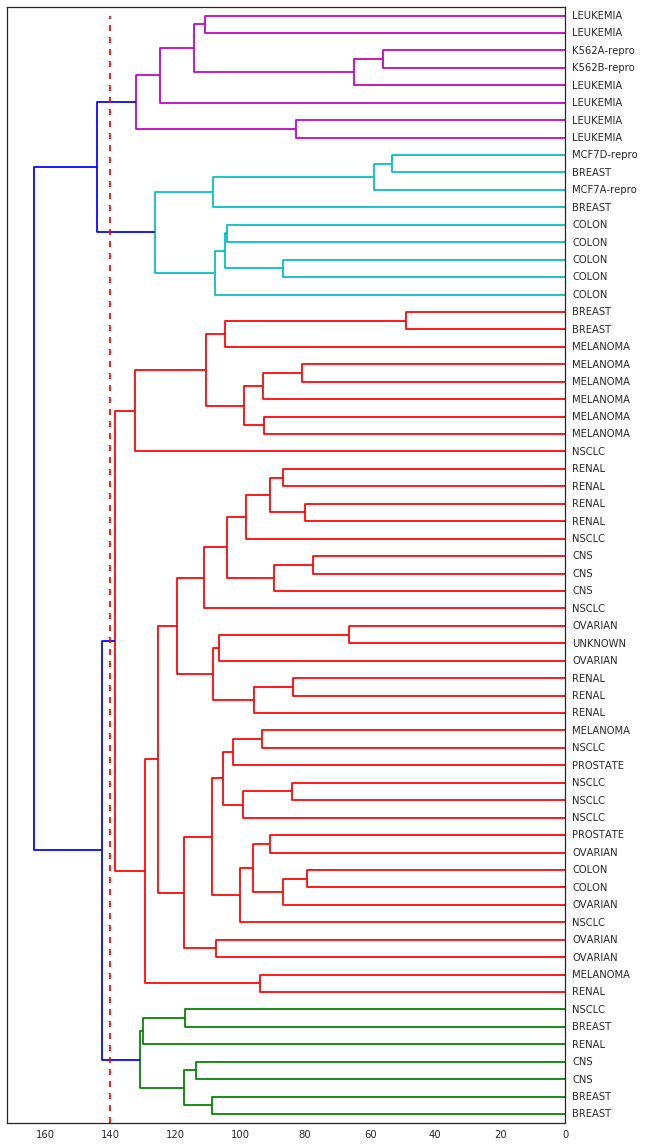

In [44]:
plt.figure(figsize=(10,20))
cut4 = hierarchy.dendrogram(hierarchy.complete(X),
                            labels=X.index, orientation='right', color_threshold=140, leaf_font_size=10)
plt.vlines(140,0,plt.gca().yaxis.get_data_interval()[1], colors='r', linestyles='dashed')

##### KMeans

In [37]:
np.random.seed(2)
km4 = KMeans(n_clusters=4, n_init=50)
km4.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=50,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [38]:
km4.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [39]:
# Observations per KMeans cluster
pd.Series(km4.labels_).value_counts().sort_index()

0     8
1    23
2    24
3     9
dtype: int64

##### Hierarchical

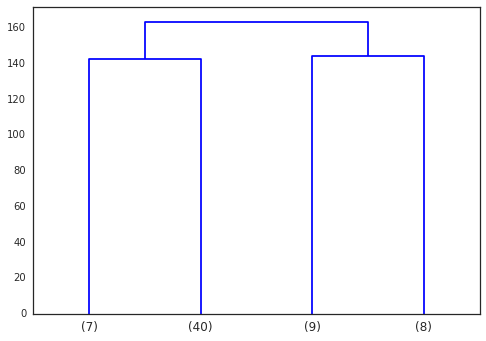

In [40]:
# Observations per Hierarchical cluster
cut4b = hierarchy.dendrogram(hierarchy.complete(X), truncate_mode='lastp', p=4, show_leaf_counts=True)

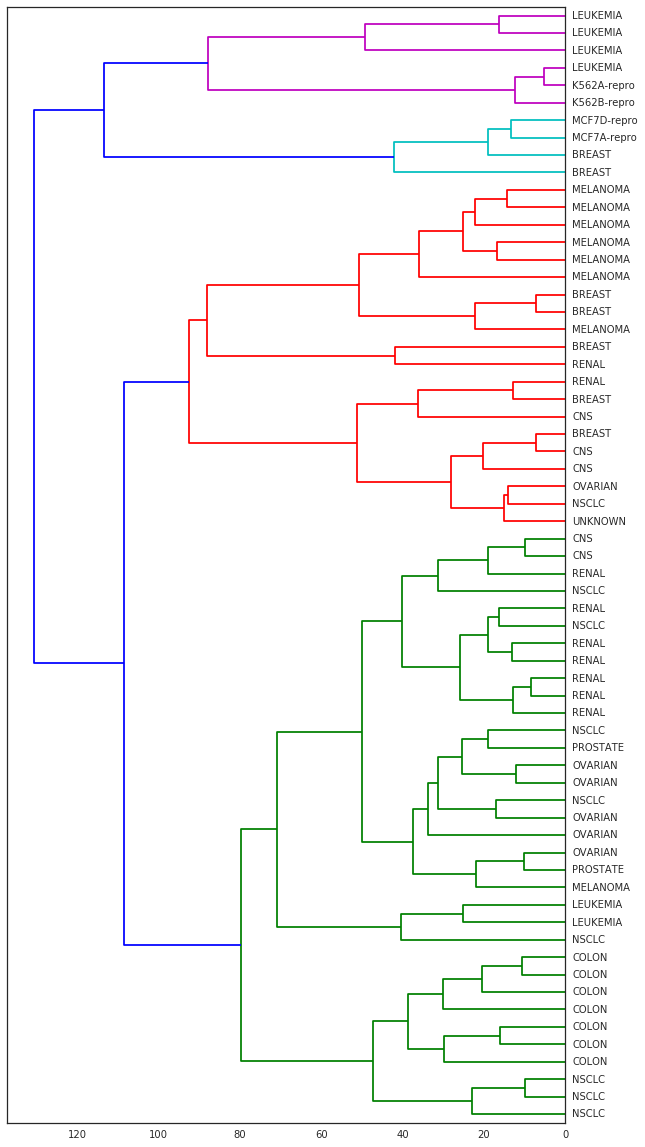

In [45]:
# Hierarchy based on Principal Components 1 to 5
plt.figure(figsize=(10,20))
pca_cluster = hierarchy.dendrogram(hierarchy.complete(df2_plot.iloc[:,:5]), labels=y.type.values, orientation='right', color_threshold=100, leaf_font_size=10)

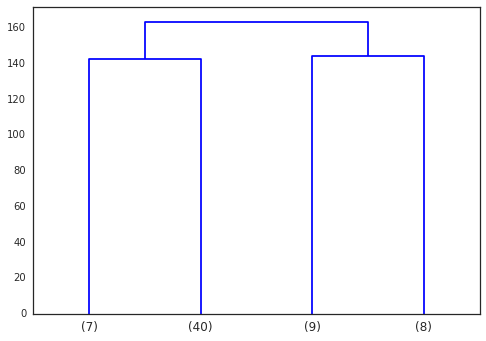

In [42]:
cut4c = hierarchy.dendrogram(hierarchy.complete(df2_plot), truncate_mode='lastp', p=4,
                             show_leaf_counts=True)
# See also color coding in plot above.